<a href="https://colab.research.google.com/github/psycoplankton/RAG-from-scratch/blob/main/rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

RAG stands for Retrieval Augmented Generation.
The goal of RAG is to take the information and pass it to an LLM so it can generate outputs based on that information.

* Retrieval - Find relevant information given a query, e.g. If we have a document then based on the given qurey, we find relevant information from that document.

* Augment - We take the retrieved information and augment it (modify it a little) and pass it to the LLM as a prompt.

* Generation - use the prompt that was generated in the above two steps and generate outputs.

The main goal is using a RAG is to generate output that is relevant to our needs. Asking a LLM straightaway will give us a very general answer as the LLMs are trained on a very large dataset and can provide only overviews for any query.

1) RAGs help prevent hallucinations in LLMs and generate more factual data.

2) Work with custom data - Many base LLMs are trained with internet-scale data. This means that have a great understanding of any topic but not in depth knowledge of it.

Use cases of RAG are

* Textbook Q&A.
* Email queries.
* Customer support Q&A.

many more.

![simple-local-rag-workflow-flowchart.png](attachment:simple-local-rag-workflow-flowchart.png)

1) use any PDF(s)

2) Format the text of the PDF textbook ready for an embedding model.

3) Embed all the chunks for text in the textbook and turn into numerical representations (embedding) which can store for later.

4) Build a retreival system that uses vector search to find relevant chunk of text based on a query.  

5) Create a prompt that incorporates the retreived pieces of text.

6) Generate an answer to query based on the passages of the PDF(s) with an LLM.

In [75]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Importing and Pre-Processing The PDF(s)

In [2]:
"""Installs required only for google colab."""
import os
if "COLAB_GPU" in os.environ:
    print(f"[INFO] Running in Google Colab, installing requirements.")
    #!pip install -U torch # requires torch 2.1.1+, that's why we have to install.
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm
    !pip install sentence-transformers
    !pip install accelerate #quantization model loading.
    !pip install bitsandbytes
    !pip install flash-attn --no-build-isolation # for using flash attention


[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 65.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_c

In [3]:
import os
import requests

#Get the PDF document paths
pdf_path = r"human-nutrition-text.pdf"

#Download PDF
if not os.path.exists(pdf_path):
    print(f"[INFO] file does not exist, downloading...")

    #enter the url of the PDF
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    #filepath where it should be saved
    filepath = pdf_path

    #send a GET request to the URL
    response = requests.get(url)

    #check if request was successful
    if response.status_code == 200:
        with open(filepath, 'wb') as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {filepath}")
    else:
        print(f"[INFO] Failed to download the file. Status Code : {response.status_code}")

else:
    print(f"File exists")

[INFO] file does not exist, downloading...
[INFO] The file has been downloaded and saved as human-nutrition-text.pdf


In [4]:
import fitz #comes from PyMuPDF
from tqdm.auto import tqdm
from typing import List

def text_formatter(text : str) -> str:
    """Performs minor fomratting on text.
    Replaces the next line escape character with a space."""
    cleaned_text = text.replace('/n', '').strip()

    """If other pre-processing steps need to be done, they can be
    put down here"""

    return cleaned_text

#Open PDF using fitz and get lines/pages
#Note: this only focuses on text, rather than images/figures etc.

def open_and_read_pdf(pdf_path : str) -> List[dict]:
    """
    Opens a PDF file reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str) : The file path to the PDF document to be opened and read.

    Returns:
        List[dict] : A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the page number,
        for each page
    """
    doc = fitz.open(pdf_path)
    pages_and_text = []

    for page_number, page in tqdm(enumerate(doc)): #opens the document with page_number and pages as the two unique Ids
        text= page.get_text() #get text in UTF-8
        text = text_formatter(text)
        pages_and_text.append({
            "page_number": page_number - 41, #accounting for all the introductory pages.
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sentence_count_raw": len(text.split(".")),
            "page_token_count": len(text)/4, #i token = 4character
            "text": text
        })

    return pages_and_text

pages_and_text = open_and_read_pdf(pdf_path = pdf_path)
pages_and_text[:2]


0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [5]:
import random
random.sample(pages_and_text, k=3)

[{'page_number': 910,
  'page_char_count': 987,
  'page_word_count': 149,
  'page_sentence_count_raw': 46,
  'page_token_count': 246.75,
  'text': 'Nutrient \nAdult Males \nAdult Females \nVitamin A (mcg) \n900.0 \n700.0 \nVitamin B6 (mg) \n1.3 \n1.3 \nVitamin B12\xa0\xa0(mcg) \n2.4 \n2.4 \nVitamin C (mg) \n90.0 \n75.0 \nVitamin D (mcg) \n5.0 \n5.0 \nVitamin E (mg) \n15.0 \n15.0 \nVitamin K(mcg) \n120.0 \n90.0 \nCalcium (mg) \n1,000.0 \n1,000.0 \nFolate (mcg) \n400.0 \n400.0 \nIron (mg) \n8.0 \n18.0 \nMagnesium (mg) \n\xa0400.0 \n310.0 \nNiacin (mg) \n16.0 \n14.0 \nPhosphorus (mg) \n700.0 \n700.0 \nRiboflavin (mg) \n1.3 \n1.1 \nSelenium \n55.0 \n55.0 \nThiamin (mg) \n1.2 \n1.1 \n\xa0Zinc (mg) \n11.0 \n\xa08.0 \nSource: Institute of Medicine. 2006. Dietary Reference Intakes: The \nEssential Guide to Nutrient Requirements. Washington, DC: The \nNational Academies Press. https:/\n/doi.org/10.17226/11537. Accessed \nDecember 10, 2017. \nNutritional Concerns in Young Adulthood \nThere are a

In [6]:
"""Let's now convert the dictionary into a dataframe, in order to get some
statistics of the data. Also to increase readability."""
import pandas as pd
df = pd.DataFrame(pages_and_text)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,42,1,80.00,Human Nutrition: 2020 \nEdition \nUNIVERSITY O...
3,-38,212,30,3,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,114,3,199.25,Contents \nPreface \nUniversity of Hawai‘i at ...


In [7]:
df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00000,1208.000000,1208.000000,1208.000000,1208.000000
mean,562.50000,1148.519868,172.305464,14.180464,287.129967
std,348.86387,560.397639,86.274039,9.544587,140.099410
min,-41.00000,0.000000,1.000000,1.000000,0.000000
25%,260.75000,762.750000,110.000000,8.000000,190.687500
50%,562.50000,1230.500000,182.500000,13.000000,307.625000
75%,864.25000,1605.000000,238.000000,19.000000,401.250000
max,1166.00000,2308.000000,394.000000,82.000000,577.000000


Let's plot the token count and sentence count per page in order to get an idea of the distribution of the text throughout the book.

<Axes: >

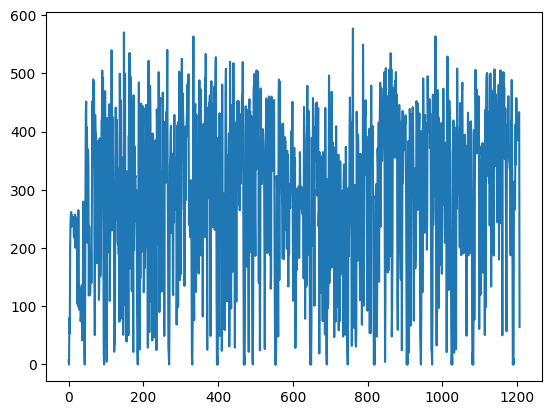

In [8]:
df['page_token_count'].plot()

<Axes: >

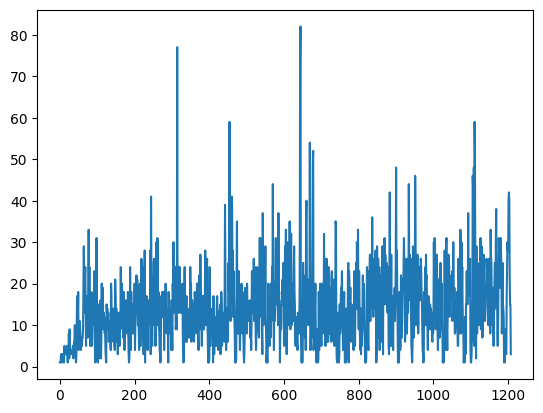

In [9]:
df['page_sentence_count_raw'].plot()

More or less, it is around 10-20 sentences per page, and the mean is 14, with a few outliers.

The ideal way of processing text before embedding it is still an active area of research.

A simple method I've found helpful is to break the text into chunks of sentences.

As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks
 -> use the embeddings`

**How to do this?**

1) Either use `text.split()`, like we already did.
2) Or use NLP library such as `spaCy` or `nltk`.

spaCy : https://spacy.io/
nltk : https://www.nltk.org/


In [10]:
#Let's use spaCy
from spacy.lang.en import English

nlp = English()

#Add a sentencizer pipeline, see https://spacy.io/api/sentencizer
#sentencizer has a inbuilt list of punctuation which helps it to
# identify end of sentences. eg. , !, ;, etc.
nlp.add_pipe("sentencizer")

#create document instance as an example
doc = nlp("This is a sentece! This is another. I like elephants.")
assert len(list(doc.sents)) == 3

#priont out our sentences split
list(doc.sents)

[This is a sentece!, This is another., I like elephants.]

In [11]:
#lets create a pipeline
for item in tqdm(pages_and_text):
    item['sentences'] = list(nlp(item['text']).sents)

    #make sure all sentences are strings
    item['sentences'] = [str(sentence) for sentence in item['sentences']]

    #count the sentences and add it as a column in dataframe
    item['page_sentence_count_spacy'] = len(item['sentences'])

df = pd.DataFrame(pages_and_text)
df

  0%|          | 0/1208 [00:00<?, ?it/s]

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences,page_sentence_count_spacy
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition,[Human Nutrition: 2020 Edition],1
1,-40,0,1,1,0.00,,[],0
2,-39,320,42,1,80.00,Human Nutrition: 2020 \nEdition \nUNIVERSITY O...,[Human Nutrition: 2020 \nEdition \nUNIVERSITY ...,1
3,-38,212,30,3,53.00,Human Nutrition: 2020 Edition by University of...,[Human Nutrition: 2020 Edition by University o...,1
4,-37,797,114,3,199.25,Contents \nPreface \nUniversity of Hawai‘i at ...,[Contents \nPreface \nUniversity of Hawai‘i at...,2
...,...,...,...,...,...,...,...,...
1203,1162,1676,217,40,419.00,39. Exercise 10.2 & 11.3 reused “Egg Oval Food...,"[39., Exercise 10.2 & 11.3 reused “Egg Oval Fo...",18
1204,1163,1617,223,22,404.25,Images / Pixabay License; “Pumpkin Cartoon Ora...,[Images / Pixabay License; “Pumpkin Cartoon Or...,10
1205,1164,1715,229,15,428.75,Flashcard Images \nNote: Most images in the fl...,[Flashcard Images \nNote: Most images in the f...,13
1206,1165,1733,233,15,433.25,ShareAlike \n11. Organs reused “Pancreas Organ...,"[ShareAlike \n11., Organs reused “Pancreas Org...",13


In [12]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.52,172.31,14.18,287.13,10.32
std,348.86,560.40,86.27,9.54,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,110.00,8.00,190.69,5.00
50%,562.50,1230.50,182.50,13.00,307.62,10.00
75%,864.25,1605.00,238.00,19.00,401.25,15.00
max,1166.00,2308.00,394.00,82.00,577.00,28.00


To split our groups of sentences into chunks of 10 or less, let's create a function which accepts a list as input and recursively breaks into down into sublists of a specified size.

In [13]:
from typing import List
#define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

#create a function that recursively splits a list into desired sizes
def split_list(input_list : List,
               slice_size : int) -> List[List[str]]:
    """Splits the input_list into sublists of size slice_size (or as close as possible),

    For example, a list of 17 sentences would split into two lists of[[10], [7]]
    """

    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

#Loop through pages and texts adn split sentences into chunks
for item in tqdm(pages_and_text):
    item['sentence_chunks'] = split_list(input_list=item['sentences'],
                                         slice_size=num_sentence_chunk_size)
    item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

So far, our text dataset, `pages_and_text` contains:

* page_number
* page_char_counnt
* page_word_count
* page_sentence_count
* page_token_count
* text : whole text on a given page.
* sentences : A list of sentences.
* sentence_chunks : A list of lists which has chunks of the sentences.
* num_chunks : The number of chunks per page.


In [14]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.52,172.31,14.18,287.13,10.32,1.53
std,348.86,560.40,86.27,9.54,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,110.00,8.00,190.69,5.00,1.00
50%,562.50,1230.50,182.50,13.00,307.62,10.00,1.00
75%,864.25,1605.00,238.00,19.00,401.25,15.00,2.00
max,1166.00,2308.00,394.00,82.00,577.00,28.00,3.00


In [15]:
pages_and_text[600]['sentence_chunks']

[['Image by \nAllison \nCalabrese / \nCC BY 4.0 \nKorsakoff syndrome can cause similar symptoms as beriberi such \nas confusion, loss of coordination, vision changes, hallucinations, \nand may progress to coma and death.',
  'This condition is specific \nto alcoholics as diets high in alcohol can cause thiamin deficiency.',
  '\nOther individuals at risk include individuals who also consume diets \ntypically low in micronutrients such as those with eating disorders, \nelderly, and individuals who have gone through gastric bypass \nsurgery.5 \nFigure 9.10 The Role of Thiamin \nFigure 9.11 Beriberi, Thiamin Deficiency \n5.',
  '\xa0Fact Sheets for Health Professionals: Thiamin.',
  'National \nInstitute of Health, Office of Dietary Supplements.',
  '\n\xa0https:/\n/ods.od.nih.gov/factsheets/Thiamin-\nHealthProfessional/. Updated Feburary 11, 2016.',
  '\nAccessed October 22, 2017.',
  '\nWater-Soluble Vitamins  |  559']]

**Splitting each chunk into its own item**

We'd Like to embed each chunk of sentence into its own numerical representation. So to do this, lets create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well as statistics about each chunk

In [16]:
import re

#Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_text):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        #Join the sentences together into a paragraph like structure, aka a chunk
        joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        #get stats about the chunk
        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk_word_count'] = len([word for word in joined_sentence_chunk.split()])
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk) / 4 # 1 token = ~4char

        pages_and_chunks.append(chunk_dict)

#How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [17]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 940,
  'sentence_chunk': 'Increasing your daily activity and shedding excess body fat helps \nto improve metabolic fitness. Physical activity also makes weight \nmanagement easier because it increases energy needs and lean \nbody mass. During moderate to vigorous activity, energy \nexpenditure raises well above the resting rate. With continuous \n5.\xa0Measuring and Evaluating Body Composition. ACSM.org.\nhttp:/\n/www.acsm.org/public-information/articles/\n2016/10/07/measuring-and-evaluating-body-\ncomposition \n940  |  The Essential Elements of Physical Fitness',
  'chunk_char_count': 529,
  'chunk_word_count': 64,
  'chunk_token_count': 132.25}]

In [18]:
df = pd.DataFrame(pages_and_chunks)
df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 \nEdition \nUNIVERSITY O...,320,42,80.00
2,-38,Human Nutrition: 2020 Edition by University of...,212,30,53.00
3,-37,Contents \nPreface \nUniversity of Hawai‘i at ...,797,116,199.25
4,-36,Lifestyles and Nutrition \nUniversity of Hawai...,976,144,244.00
...,...,...,...,...,...
1838,1164,Flashcard Images \nNote: Most images in the fl...,1329,186,332.25
1839,1164,Hazard Analysis Critical Control Points reused...,383,51,95.75
1840,1165,ShareAlike \n11. Organs reused “Pancreas Organ...,1312,175,328.00
1841,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,420,63,105.00


In [19]:
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,750.35,112.95,187.59
std,347.79,455.60,71.10,113.90
min,-41.00,14.00,3.00,3.50
25%,280.50,321.00,45.00,80.25
50%,586.00,764.00,115.00,191.00
75%,890.00,1138.00,173.00,284.50
max,1166.00,1870.00,297.00,467.50


The minimum token length is 3. Most likely it will not be of singnificant use. Let's examine some of the smaller chunks.  

In [20]:
#show all the chunks under min_token_length
min_token_length = 20
for row in df[df["chunk_token_count"] <= min_token_length].sample(10).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | text: {row[1]["sentence_chunk"]}')

Chunk token count: 17.25 | text: http:/
/www.aafp.org/afp/
2002/1001/p1217.html.
862  |  Toddler Years
Chunk token count: 6.0 | text: 1050  |  Comparing Diets
Chunk token count: 13.5 | text: Accessed October 5, 2017.
540  |  Fat-Soluble Vitamins
Chunk token count: 17.0 | text: Complementary foods include baby meats, vegetables, 
Infancy  |  837
Chunk token count: 3.75 | text: 622  |  Calcium
Chunk token count: 7.25 | text: Human Nutrition: 2020 Edition
Chunk token count: 17.75 | text: PART X 
CHAPTER 10. MAJOR 
MINERALS 
Chapter 10. Major Minerals  |  607
Chunk token count: 15.5 | text: Folate is also found in legumes, liver, and 
Pregnancy  |  787
Chunk token count: 9.75 | text: 490  |  Factors Affecting Energy Intake
Chunk token count: 17.0 | text: Updated January 2015. Accessed 
December 4, 2017.
Middle Age  |  917


In [21]:
#filter our dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_length].to_dict(orient='records')

In [22]:
len(pages_and_chunks_over_min_token_len)

1753

# Embedding our text chunks

In [23]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

#let's embed an example.
#create a list of sentences
sentences = ["The sentence transformer library provides an easy way to create embeddings",
             "sentences can be embedded one by one or in a list",
             "I like horses!"]

#encode the sentences
embeddings = embedding_model.encode(sentences)
embedding_dict = dict(zip(sentences, embeddings))

#print the embeddings
for sentence, embeddings in embedding_dict.items():
    print(f"Sentence: {sentence}")
    print(f"embeddings: {embeddings}")
    print("\n")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The sentence transformer library provides an easy way to create embeddings
embeddings: [-3.17512490e-02  3.37268040e-02 -2.52437722e-02  5.22287600e-02
 -2.35248990e-02 -6.19117822e-03  1.35026304e-02 -6.25500977e-02
  7.50825973e-03 -2.29684655e-02  2.98146568e-02  4.57555018e-02
 -3.26700397e-02  1.39847072e-02  4.18013781e-02 -5.92969656e-02
  4.26309630e-02  5.04660420e-03 -2.44552195e-02  3.98594327e-03
  3.55897769e-02  2.78742891e-02  1.84098352e-02  3.67700234e-02
 -2.29960773e-02 -3.01797111e-02  5.99519233e-04 -3.64503972e-02
  5.69104478e-02 -7.49943079e-03 -3.70004289e-02 -3.04357079e-03
  4.64354567e-02  2.36151041e-03  9.06849777e-07  7.00035319e-03
 -3.92290056e-02 -5.95698599e-03  1.38653032e-02  1.87109259e-03
  5.34202382e-02 -6.18613847e-02  2.19613388e-02  4.86051142e-02
 -4.25697900e-02 -1.69858765e-02  5.04178703e-02  1.54733742e-02
  8.12859610e-02  5.07106222e-02 -2.27497090e-02 -4.35721166e-02
 -2.18389230e-03 -2.14091521e-02 -2.01758128e-02  3.068325

In [24]:
#make a list of lists of all the chunks of sentences
text_chunks = [item['sentence_chunk'] for item in pages_and_chunks_over_min_token_len]

#embedd all the sentences
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device,
                                      )
text_chunks_embeddings = embedding_model.encode(text_chunks,
                                                batch_size=32,
                                                convert_to_tensor=True)
text_chunks_embeddings

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [25]:
#Save embeddings to a file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)

#add a column named embeddings to text_chunks_and_embeddings_df dataframe
text_chunks_and_embeddings_df['embedding'] = text_chunks_embeddings.tolist()

embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"

text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)


# RAG Search and Answer

What we are going to do is, embed our query(question), with the same embedding model as the one used to embed our pdf. Then we peform a similarity search

### Similarity Search

embeddings can be used for almost any type of data.

Similarity search is comparing embeddings of two sentences, or tokens.

In [26]:
import random
import torch
import numpy as np
import pandas as pd

#import saved file and view
text_chunks_and_embedding_df = pd.read_csv(embeddings_df_save_path)

#convert embedding column back to numpy array
text_chunks_and_embedding_df['embedding'] = text_chunks_and_embedding_df['embedding'].apply(lambda x: np.fromstring(x.strip("[]"), sep=","))
print(len(text_chunks_and_embedding_df['embedding'][0]))
#convert our embeddings into a torch .tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df['embedding'].tolist(), axis=0), dtype=torch.float32).to(device)

#convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

768


In [27]:
embeddings.shape

torch.Size([1753, 768])

In [28]:
#create the model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)


Let's create a semantic search pipeline.

1. Define a query string
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity search between the text embeddings an query embeddings.
4. Sort the results in descending order.

In [29]:
#1. define the query
query = "macronutrients functions"
print(f"Query: {query}")

#2. embed the query
#Note: it's important to use the same embeding model as the one used to embed the document.

query_embedding = embedding_model.encode(query, convert_to_tensor=True)

#3. Get the similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to calculate the dot scores of {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

#get the topk results
top_results_dot_product = torch.topk(input=dot_scores, k=5)
values, indices = top_results_dot_product

Query: macronutrients functions
[INFO] Time taken to calculate the dot scores of 1753 embeddings: 0.02408 seconds.


We can see that searching over embeddings is very fast.

But if you had 10M+ or 100M+ embeddings, you likely want to create an `index`.

An `index` is like letters in the dictionary, it helps narrow down the search space. For example, if you want to search "duck" in the dictionary, you'd start at 'd then find close words like 'du' then 'duc' etc..

n index helps narrow down the search. A famous library to perform indexing is
* `Faiss:` https://github.com/facebookresearch/faiss/wiki
and one technique that the library provides is
* `Approximate Nearest Neighbour search (ANN):` https://www.mongodb.com/resources/basics/ann-search

In [30]:
#Let's make out vector embeddings representable.
import textwrap

def print_warpped(text, wrap_length=100):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)


In [31]:
query = "macronutrient functions"
print(f"Query: {query}")
print("Results:")
#lopp through the zipped together scores and indices from torch.topk
for score, idx in zip(values, indices):
    print(f"Score: {score:4f}")
    print("Text:")
    print(pages_and_chunks[idx]['sentence_chunk'])
    print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: macronutrient functions
Results:
Score: 0.692581
Text:
Macronutrients 
Nutrients 
that 
are 
needed 
in 
large 
amounts 
are 
called 
macronutrients. There are three classes of macronutrients: 
carbohydrates, lipids, and proteins. These can be metabolically 
processed into cellular energy. The energy from macronutrients 
comes from their chemical bonds. This chemical energy is 
converted into cellular energy that is then utilized to perform work, 
allowing our bodies to conduct their basic functions. A unit of 
measurement of food energy is the calorie. On nutrition food labels 
the amount given for “calories” is actually equivalent to each calorie 
multiplied by one thousand. A kilocalorie (one thousand calories, 
denoted with a small “c”) is synonymous with the “Calorie” (with a 
capital “C”) on nutrition food labels. Water is also a macronutrient in 
the sense that you require a large amount of it, but unlike the other 
macronutrients, it does not yield calories.
Carbohydrate

**Note:** We could potentially improve the order of these results with a reranking model. A model that has been trained specifically to take search results(e.g the top 25 semantic results) and rank them in order from most likely top-1 to least least likely

See here for an open source model: https://www.mixedbread.ai/blog/mxbai-rerank-v1

(-0.5, 549.5, 849.5, -0.5)

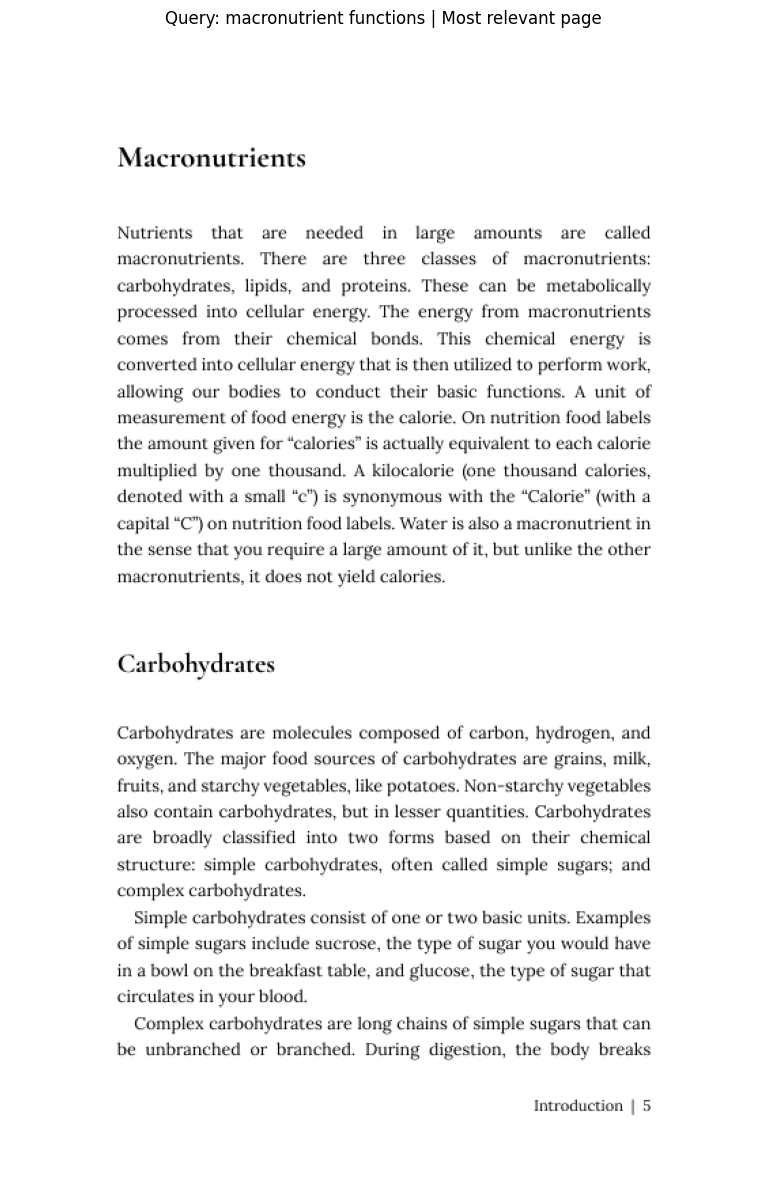

In [32]:
import fitz

#open PDF and load target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) #add 41 because first 41 pages were introductory

#get the image of the page
img = page.get_pixmap(dpi=100)


#save image (optional)
# img.save("output_filename.png") #onlty if you want to save the image
doc.close()

#convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape(img.h, img.w, img.n)

#display the image
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevant page")
plt.axis('off')

### Similarity Measures : dot product and cosine similarity

Two of the most common similaity measures between vectors are dot products and cosine similarity.
In essence, closer vectors will have higher scores, further away vectors will have lower scores.

In [33]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    """Norm is the euclidean distance from the origin. Or the magnitude of the vector.
    norm = torch.sqrt(torch.sum(vector**2)) ** is point-wise exponentiation"""
    return torch.dot(vector1, vector2) / (torch.norm(vector1) * torch.norm(vector2))


### Functionizing our semantic search pipeline

Let's put all the steps from above for semantic search into a function or two so we can repeat the workflow.

In [34]:
def retrieve_relevant_resources(query : str,
                                embeddings : torch.Tensor,
                                model : SentenceTransformer = embedding_model,
                                n_resources_to_return : int = 5,
                                print_time : bool = True):
    """Performs a semantic search and returns the top k results."""

    #embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    #get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to calculate the dot scores of {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)
    return scores, indices

def print_top_results_and_scores(query : str,
                                embeddings : torch.Tensor,
                                model : SentenceTransformer = embedding_model,
                                n_resources_to_return : int = 5,
                                print_time : bool = True):
    """Prints the top k results and their scores."""
    scores, indices = retrieve_relevant_resources(query=query,
                                                   embeddings=embeddings,
                                                   model=model,
                                                   n_resources_to_return=n_resources_to_return,
                                                   print_time=print_time)
    print(f"Query: {query}")
    print("Results:")
    #loop through the zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:4f}")
        print("Text:")
        print(pages_and_chunks[idx]['sentence_chunk'])
        print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
        print("\n")


In [35]:
query = "foods in high fiber"
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

print_top_results_and_scores(query=query,
                             embeddings=embeddings,
                             model=embedding_model,
                             n_resources_to_return=5,
                             print_time=True)

[INFO] Time taken to calculate the dot scores of 1753 embeddings: 0.00007 seconds.
Query: foods in high fiber
Results:
Score: 0.685484
Text:
• Change it up a bit and experience the taste and satisfaction of 
other whole grains such as barley, quinoa, and bulgur.
• Eat snacks high in fiber, such as almonds, pistachios, raisins, 
and air-popped popcorn.
Add an artichoke and green peas to your dinner plate more 
276  |  Carbohydrates and Personal Diet Choices
Page Number: 276


Score: 0.663425
Text:
Dietary fiber is categorized as either water-soluble or insoluble.
Some examples of soluble fibers are inulin, pectin, and guar gum 
and they are found in peas, beans, oats, barley, and rye. Cellulose 
and lignin are insoluble fibers and a few dietary sources of them 
are whole-grain foods, flax, cauliflower, and avocados. Cellulose is 
the most abundant fiber in plants, making up the cell walls and 
providing structure. Soluble fibers are more easily accessible to 
bacterial enzymes in the la

# Getting an LLM for local generation

### Check our local GPU memory

In [36]:
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = (gpu_memory_bytes / (2**30))
print(f"GPU memory available : {gpu_memory_gb} GB")

GPU memory available : 14.74810791015625 GB


In [37]:
!nvidia-smi

Tue Aug  6 03:52:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0              32W /  70W |   1993MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [38]:
from google.colab import userdata
from huggingface_hub import notebook_login

#Huggingface API token
huggingfacehub_api_token = userdata.get('HUGGINGFACEHUB_API_KEY')
notebook_login(huggingfacehub_api_token)


To get a model running, we need
* A quantization config(optional): a config on what precision to load the model (eg. 8bit, 4bit)


In [40]:
# Load model directly
# also, flash attention is only available for some of the GPUs. we would also have to check this
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig


model_id = "google/gemma-7b-it"
#create a qunatization
quantization_config = BitsAndBytesConfig(load_in_4_bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)


#check the compute-capability of the device.
print(f"Compute capability: {torch.cuda.get_device_capability()}")
if is_flash_attn_2_available() and torch.cuda.get_device_capability()[0] > 8 :
    attn_implementaion = 'flash_attnetion_2'
    print("Flash attention 2 is available")
else:
    attn_implementation = 'sdpa'
    print("Flash attention 2 is not available")

#Instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b-it")
model = AutoModelForCausalLM.from_pretrained("google/gemma-7b-it",
                                             torch_dtype=torch.float16,
                                             quantization_config=quantization_config,
                                             low_cpu_mem_usage = True,
                                             attn_implementation = attn_implementation,
                                             device_map="auto")

Unused kwargs: ['load_in_4_bit']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Compute capability: (7, 5)
Flash attention 2 is not available


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [41]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(model=model)

4662144000

In [44]:
def get_model_memsize(model: torch.nn.Module):
    #Get model parameters and buffer size
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buffer.nelement() * buffer.element_size() for buffer in model.buffers()])

    #calucalte model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_gb = model_mem_bytes / (2**30)

    return {
        "model_mem_bytes": model_mem_bytes,
        "model_mem_gb": model_mem_gb
    }

get_model_memsize(model)

{'model_mem_bytes': 5448765440, 'model_mem_gb': 5.074558258056641}

### Generating text with LLM



In [45]:
input_text = "What are macronutrients, and what roles do they play in human body?"

#Create a prompt template for instrcution-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

#Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)

print(f"\nPrompt (formatted): {prompt}")


Prompt (formatted): <bos><start_of_turn>user
What are macronutrients, and what roles do they play in human body?<end_of_turn>
<start_of_turn>model



In [48]:
%%time

#tokenize input text (turn it into numbers ) and send it to the GPU
input_ids = tokenizer(prompt,
                      return_tensors = 'pt').to(device)

# Generate outputs from local LLM
outputs = model.generate(**input_ids,
                             max_new_tokens=256)

print(f"Model output (tokens): {outputs[0]}\n" )

CPU times: user 14.6 s, sys: 0 ns, total: 14.6 s
Wall time: 14.5 s


tensor([[     2,      2,    106,   1645,    108,   1841,    708, 186809, 184592,
         235269,    578,   1212,  16065,    749,    984,   1554,    575,   3515,
           2971, 235336,    107,    108,    106,   2516,    108,  12298,   1695,
         184592,    708,    573,   2149, 186809, 184592,    674,    573,   2971,
           4026,    575,   2910,  15992,    577,   1411,  10338, 235265,   2365,
            708,  72780, 235269,  20361, 235269,    578,  61926, 235265,    109,
            688, 156615,  56227,  66058,    109, 235287,  34428,   4134,    604,
            573,   2971, 235265,    108, 235287,  13332,  41748,   5330,   9347,
           5902, 235265,    108, 235287,  13332,   2500, 155248, 235269,    948,
            603,  14608,   4134, 235265,    108, 235287,  13332,   2500,  20149,
         235269,    948,    603,   2845,    604,  59194,   2962, 235265,    109,
            688, 216954,  66058,    109, 235287,   8108,    578,  12158,  29703,
         235265,    108, 235

In [49]:
#decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (text): {outputs_decoded}")

Model output (text): <bos><bos><start_of_turn>user
What are macronutrients, and what roles do they play in human body?<end_of_turn>
<start_of_turn>model
Macronutrients are the three macronutrients that the body needs in large amounts to function properly. They are carbohydrates, proteins, and fats.

**Carbohydrates:**

* Provide energy for the body.
* Help regulate blood sugar levels.
* Help build glycogen, which is stored energy.
* Help build fiber, which is important for digestive health.

**Proteins:**

* Build and repair tissues.
* Make enzymes and other chemicals.
* Help build muscle mass and strength.
* Help regulate blood sugar levels.

**Fats:**

* Provide energy for the body.
* Help absorb vitamins and minerals.
* Help build cell membranes.
* Help regulate blood sugar levels.

The body needs a balance of all three macronutrients to function properly. If you do not get enough of one of the macronutrients, you can experience health problems. For example, if you do not get enough

In [56]:
query_list = [
    "What are the primary macronutrients, and what roles do they play in human health?",
    "How does fiber intake affect digestive health, and what are some high-fiber foods?",
    "What are the benefits and potential risks of a ketogenic diet?",
    "How does vitamin D deficiency impact overall health, and what are some natural sources of vitamin D?",
    "What is the importance of hydration, and how much water should an average adult consume daily?",
    "How can antioxidants help prevent chronic diseases, and which foods are rich in antioxidants?",
    "What are the nutritional differences between plant-based and animal-based proteins?",
    "How does sugar consumption affect metabolic health, and what are some strategies to reduce sugar intake?"

]

In [52]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

#get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings,
                                              model=embedding_model,
                                              n_resources_to_return=5,
                                              print_time=True)
scores, indices

Query: Describe the impact of omega-3 and omega-6 fatty acids on cardiovascular health. Compare their sources, recommended intake levels, and the physiological mechanisms through which they influence heart disease risk.
[INFO] Time taken to calculate the dot scores of 1753 embeddings: 0.00008 seconds.


(tensor([0.6486, 0.6395, 0.6175, 0.6126, 0.6113], device='cuda:0'),
 tensor([498, 526, 472, 541, 552], device='cuda:0'))

### Augment our prompt with context items

The concept of augmenting a prompt with context items is also referred as prompt engineering.

In [76]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:

    context = "-" + "\n-".join([item['sentence_chunk'] for item in context_items])
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""


    prompt = base_prompt.format(context=context, query=query)
    return prompt

query = random.choice(query_list)
print(f"Query : {query}")

#get relevant resources
scores, indices = retrieve_relevant_resources(query = query, embeddings = embeddings)

#create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

#Format our prompt
prompt = prompt_formatter(query=query, context_items = context_items)
print(f"\nPrompt : {prompt}")

Query : What is the importance of hydration, and how much water should an average adult consume daily?
[INFO] Time taken to calculate the dot scores of 1753 embeddings: 0.00008 seconds.

Prompt : Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells fr

In [77]:
%%time

#tokenize input text (turn it into numbers ) and send it to the GPU
input_ids = tokenizer(prompt,
                      return_tensors = 'pt').to(device)

# Generate outputs from local LLM
outputs = model.generate(**input_ids,
                         temperature=0.7,
                         do_sample=True,
                         max_new_tokens=2048) # Increased max_new_tokens

output_text = tokenizer.decode(outputs[0])
RAG_answer = output_text.replace(prompt, "")
print(f"Model output : {RAG_answer}\n" )

Model output : <bos> Hydration is crucial for physical performance, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. To maintain optimal performance and overall health, adults should aim for daily water intake of 3.7 liters for males and 2.7 liters for females. This balance between water intake and output is essential for regulating water balance and preventing dehydration.<eos>

CPU times: user 5.93 s, sys: 260 ms, total: 6.19 s
Wall time: 6.18 s
